# Introduction

I want to build a very simple draft predictor model.

Given the following inputs: 1) draft order number return a distribution over heros to predict which hero will be picked for the input draft order number.

Inputs: draft order number
Outputs: hero name (multi-class classification)

Training dataset

Drafts from dpc 2021-2022 tour 1

from every game (or as many as I was able to get) extract the draft.
Make an array of draft order number and which hero was picked.

## Future work

could add teams, their region and if they are radiant or dire as inputs. To do this you can encode these categorical variables using an Embedding layer.
It would be interesting to examine the embeddings and see if different regions / teams that draft similarly are close together in this embedding space.

This work currently doesn't really go beyond the data frequency. i.e. the models only model the frequency of each hero appearing in each draft order number.
This indirectly includes information on which heros are good or bad because in general 'good' heros will be picked more often than not (because teams are trying to win).
(So really heros that teams thing are good get picked more often than not).

How can we include something in the model to go beyond just the statistics of the data? Can we do something with the outcome of the match? For example if a hero is picked or banned by a team and that team ends up winning the match then that pick / ban should be weighted more. By winning this is a potential indication that that pick/ban was particularly good.

So could we weight a pick/ban more if that team won the match? This would then change the model from simply modelling the statistics to a model that predicts which heroes were "best"?

In [1]:
import pandas as pd
import json
import glob
import datetime
import numpy as np

In [2]:
pd.set_option('display.max_rows', 121)
pd.set_option('display.max_columns', 25)

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams.update({'font.size': 16})

In [102]:
import seaborn as sns
sns.set_theme()

In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

In [5]:
def convert_time(s):
    return datetime.datetime.fromtimestamp(s).strftime('%Y-%m-%d %H:%M:%S.%f')

In [6]:
def read_json_file(filename):
    with open(filename, "r") as f:
        return json.load(f)

In [7]:
hero_map = pd.read_json("hero_map.json")
hero_map.set_index('idx', inplace=True)

In [8]:
hero_map.loc[64].values[0]

'Jakiro'

In [9]:
filenames = glob.glob("stratz_match_data_2021_2022_tour_1/*")

In [10]:
filenames

['stratz_match_data_2021_2022_tour_1/NA.json',
 'stratz_match_data_2021_2022_tour_1/SEA.json',
 'stratz_match_data_2021_2022_tour_1/EEU.json',
 'stratz_match_data_2021_2022_tour_1/SA.json',
 'stratz_match_data_2021_2022_tour_1/WEU.json',
 'stratz_match_data_2021_2022_tour_1/CN.json']

In [11]:
data = {}
for filename in filenames:
    key = filename.split("/")[-1].split(".")[0]
    data[key] = read_json_file(filename)

In [12]:
hero_map.loc[71]

hero    Spirit Breaker
Name: 71, dtype: object

In [13]:
data["NA"]["data"]["league"]['matches'][0]['id']

6388378756

In [14]:
data["NA"]["data"]["league"]['matches'][0]['stats']['pickBans'][4]

{'heroId': 71,
 'isPick': True,
 'order': 4,
 'playerIndex': 0,
 'team': None,
 'wasBannedSuccessfully': None}

In [15]:
[p['playerIndex'] for p in data["NA"]["data"]["league"]['matches'][0]['stats']['pickBans']]

[0, 0, 0, 0, 0, 5, 7, 2, 0, 0, 0, 0, 0, 0, 9, 3, 4, 6, 0, 0, 0, 0, 1, 8]

In [16]:
[p['playerIndex'] for p in data["NA"]["data"]["league"]['matches'][1]['stats']['pickBans']]

[0, 0, 0, 0, 0, 9, 7, 3, 0, 0, 0, 0, 0, 0, 6, 2, 4, 8, 0, 0, 0, 0, 1, 5]

In [17]:
[p['playerIndex'] for p in data["NA"]["data"]["league"]['matches'][-1]['stats']['pickBans']]

[0, 0, 0, 0, 2, 7, 5, 3, 0, 0, 0, 0, 0, 0, 9, 4, 1, 8, 0, 0, 0, 0, 0, 6]

In [18]:
phases_map = {'first ban phase':[0,1,2,3], 'first pick phase':[4,5,6,7], 'second ban phase':[8,9,10,11,12,13], 'second pick phase':[14,15,16,17], 'third ban phase':[18,19,20,21], 'thrid pick phase':[22,23]}
names = ['ban','ban','ban','ban','pick','pick','pick','pick','ban','ban','ban','ban','ban','ban','pick','pick','pick','pick','ban','ban','ban','ban','pick','pick']
pick_ban_order = pd.DataFrame({
    'index':np.arange(len(names)),
    'pick_order':np.arange(len(names))+1,
    'name':names
}).set_index('index')


# make a column for the name of the phase the pick/ban occurs in
for phase_name in list(phases_map.keys()):
    pick_ban_order.loc[pick_ban_order.index[phases_map[phase_name]], 'phases'] = phase_name

In [19]:
pick_ban_order

pick_order  name             phases
index                                     
0               1   ban    first ban phase
1               2   ban    first ban phase
2               3   ban    first ban phase
3               4   ban    first ban phase
4               5  pick   first pick phase
5               6  pick   first pick phase
6               7  pick   first pick phase
7               8  pick   first pick phase
8               9   ban   second ban phase
9              10   ban   second ban phase
10             11   ban   second ban phase
11             12   ban   second ban phase
12             13   ban   second ban phase
13             14   ban   second ban phase
14             15  pick  second pick phase
15             16  pick  second pick phase
16             17  pick  second pick phase
17             18  pick  second pick phase
18             19   ban    third ban phase
19             20   ban    third ban phase
20             21   ban    third ban phase
21             22   ban    third ban phase
22             23  pick   thrid pick phase
23             24  pick   thrid pick phase

In [20]:
def get_rows_df(data_matches, region):
    ks = ['id', 'radiantTeamId', 'direTeamId', 'startDateTime', 'firstBloodTime', 'didRadiantWin']
    rows = []
    for i, m in enumerate(data_matches):
        row = {k:data_matches[i][k] for k in ks}

        row['radiantTeam'] = data_matches[i]['radiantTeam']['name']
        row['direTeam'] = data_matches[i]['direTeam']['name']
        row['startDateTime'] = convert_time(row['startDateTime'])
        
        
        row['series_type'] = data_matches[i]['series']['type']
        
        row['series_match_ids'] = [match_ids['id'] for match_ids in data_matches[i]['series']['matches']]
        
        
        row['region'] = region
        
        stats = data_matches[i]['stats']
        try:
            for j, pb in enumerate(stats['pickBans']):
                row['heroId'] = pb['heroId']
                row['heroName'] = hero_map.loc[pb['heroId']].values[0]
                row['order'] = pb['order']
                row['isPick'] = pb['isPick']
                
                rows.append(list(row.values()))
        except:
            pass
            print(f"case failed: index: {i}, match id: {m['id']}")
        
    cols = list(row.keys())
    # print(cols)
    df = pd.DataFrame(rows, columns=cols)
    return df

In [21]:
dfs = []
for k in data.keys():
    print(f"region: {k}")
    dfs.append(get_rows_df(data[k]["data"]["league"]['matches'], k))
df = pd.concat(dfs)

region: NA
region: SEA
case failed: index: 28, match id: 6366198239
case failed: index: 51, match id: 6315059728
region: EEU
region: SA
region: WEU
case failed: index: 67, match id: 6299515051
region: CN


In [22]:
dfs[0]

id  radiantTeamId  direTeamId               startDateTime  \
0     6388378756        7819028     8376426  2022-01-21 00:00:01.000000   
1     6388378756        7819028     8376426  2022-01-21 00:00:01.000000   
2     6388378756        7819028     8376426  2022-01-21 00:00:01.000000   
3     6388378756        7819028     8376426  2022-01-21 00:00:01.000000   
4     6388378756        7819028     8376426  2022-01-21 00:00:01.000000   
...          ...            ...         ...                         ...   
1613  6299750006        8272699     7390454  2021-11-30 20:06:52.000000   
1614  6299750006        8272699     7390454  2021-11-30 20:06:52.000000   
1615  6299750006        8272699     7390454  2021-11-30 20:06:52.000000   
1616  6299750006        8272699     7390454  2021-11-30 20:06:52.000000   
1617  6299750006        8272699     7390454  2021-11-30 20:06:52.000000   

      firstBloodTime  didRadiantWin      radiantTeam         direTeam  \
0                -14           True        4 Zoomers  Wildcard Gaming   
1                -14           True        4 Zoomers  Wildcard Gaming   
2                -14           True        4 Zoomers  Wildcard Gaming   
3                -14           True        4 Zoomers  Wildcard Gaming   
4                -14           True        4 Zoomers  Wildcard Gaming   
...              ...            ...              ...              ...   
1613              22          False  Simply TOOBASED      Quincy Crew   
1614              22          False  Simply TOOBASED      Quincy Crew   
1615              22          False  Simply TOOBASED      Quincy Crew   
1616              22          False  Simply TOOBASED      Quincy Crew   
1617              22          False  Simply TOOBASED      Quincy Crew   

        series_type          series_match_ids region  heroId  \
0     BEST_OF_THREE  [6388378756, 6388326281]     NA      98   
1     BEST_OF_THREE  [6388378756, 6388326281]     NA      76   
2     BEST_OF_THREE  [6388378756, 6388326281]     NA      39   
3     BEST_OF_THREE  [6388378756, 6388326281]     NA      63   
4     BEST_OF_THREE  [6388378756, 6388326281]     NA      71   
...             ...                       ...    ...     ...   
1613  BEST_OF_THREE  [6299811091, 6299750006]     NA      35   
1614  BEST_OF_THREE  [6299811091, 6299750006]     NA       6   
1615  BEST_OF_THREE  [6299811091, 6299750006]     NA      94   
1616  BEST_OF_THREE  [6299811091, 6299750006]     NA      47   
1617  BEST_OF_THREE  [6299811091, 6299750006]     NA     106   

               heroName  order  isPick  
0             Timbersaw      0   False  
1     Outworld Devourer      1   False  
2         Queen of Pain      2   False  
3                Weaver      3   False  
4        Spirit Breaker      4    True  
...                 ...    ...     ...  
1613             Sniper     19   False  
1614        Drow Ranger     20   False  
1615             Medusa     21   False  
1616              Viper     22    True  
1617       Ember Spirit     23    True  

[1618 rows x 15 columns]

In [507]:
df=pd.concat([df_[['heroId', 'heroName', 'order', 'isPick', 'region', 'radiantTeam', 'direTeam']] for df_ in dfs], axis=0)


# choose a specific region?
# df = df[df['region']=='CN']
# df = df[df['region']=='WEU']
# df = df[df['region']=='EEU']

# choose a specific team?
# df = df[(df['direTeam']=='OG') | (df['radiantTeam']=='OG')]

In [508]:
df

heroId           heroName  order  isPick region radiantTeam  \
0         98          Timbersaw      0   False     NA   4 Zoomers   
1         76  Outworld Devourer      1   False     NA   4 Zoomers   
2         39      Queen of Pain      2   False     NA   4 Zoomers   
3         63             Weaver      3   False     NA   4 Zoomers   
4         71     Spirit Breaker      4    True     NA   4 Zoomers   
...      ...                ...    ...     ...    ...         ...   
1723      39      Queen of Pain     19   False     CN       EHOME   
1724      41      Faceless Void     20   False     CN       EHOME   
1725      13               Puck     21   False     CN       EHOME   
1726      15              Razor     22    True     CN       EHOME   
1727      48               Luna     23    True     CN       EHOME   

             direTeam  
0     Wildcard Gaming  
1     Wildcard Gaming  
2     Wildcard Gaming  
3     Wildcard Gaming  
4     Wildcard Gaming  
...               ...  
1723   phoenix gaming  
1724   phoenix gaming  
1725   phoenix gaming  
1726   phoenix gaming  
1727   phoenix gaming  

[9928 rows x 7 columns]

<AxesSubplot:ylabel='Frequency'>

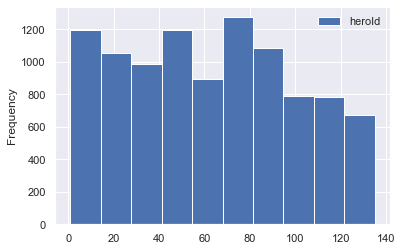

In [509]:
df.plot.hist(y='heroId')

In [510]:
print("heros not picked at all")
set(hero_map['hero'].values) - set(df['heroName'].unique())

heros not picked at all


{'Meepo', 'Omniknight'}

In [511]:
df['heroName'].unique().shape

(119,)

In [512]:
hero_map['hero'].values

array(['Monkey King', 'Mars', 'Weaver', 'Invoker', 'Tidehunter',
       'Beastmaster', 'Lina', 'Io', 'Bane', 'Medusa', 'Batrider',
       'Storm Spirit', 'Queen of Pain', 'Kunkka', 'Ember Spirit', 'Puck',
       'Luna', 'Terrorblade', 'Morphling', 'Void Spirit', 'Pangolier',
       'Snapfire', 'Night Stalker', 'Faceless Void', 'Razor',
       'Bloodseeker', 'Templar Assassin', 'Ursa', 'Phantom Lancer',
       'Outworld Devourer', 'Spirit Breaker', 'Disruptor', 'Sven', 'Lion',
       'Gyrocopter', 'Nyx Assassin', 'Lycan', 'Tiny', 'Shadow Demon',
       'Legion Commander', 'Leshrac', 'Lifestealer', 'Timbersaw', 'Doom',
       'Phantom Assassin', 'Viper', 'Slark', 'Grimstroke', 'Silencer',
       'Keeper of the Light', 'Mirana', 'Rubick', 'Wraith King', 'Magnus',
       'Sand King', 'Abaddon', 'Ogre Magi', 'Dark Willow', 'Elder Titan',
       'Death Prophet', 'Dark Seer', 'Troll Warlord', 'Dawnbreaker',
       'Enchantress', 'Vengeful Spirit', 'Clockwerk', 'Omniknight',
       'Treant Pro

In [513]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(hero_map['hero'].values.reshape(-1, 1))
# enc = LabelEncoder()
# enc.fit(hero_map['hero'].values.reshape(-1,))

OneHotEncoder(handle_unknown='ignore')

In [514]:
enc.transform([["Zeus"]]).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [515]:
enc.transform([["Zeus"]]).toarray().shape

(1, 121)

In [516]:
enc.inverse_transform(enc.transform([["Zeus"]]).toarray())
# enc.inverse_transform(enc.transform([["Zeus"]])) #.toarray())

array([['Zeus']], dtype=object)

In [517]:
enc.categories_

[array(['Abaddon', 'Alchemist', 'Ancient Apparition', 'Anti-Mage',
        'Arc Warden', 'Axe', 'Bane', 'Batrider', 'Beastmaster',
        'Bloodseeker', 'Bounty Hunter', 'Brewmaster', 'Bristleback',
        'Broodmother', 'Centaur Warrunner', 'Chaos Knight', 'Chen',
        'Clinkz', 'Clockwerk', 'Crystal Maiden', 'Dark Seer',
        'Dark Willow', 'Dawnbreaker', 'Dazzle', 'Death Prophet',
        'Disruptor', 'Doom', 'Dragon Knight', 'Drow Ranger',
        'Earth Spirit', 'Earthshaker', 'Elder Titan', 'Ember Spirit',
        'Enchantress', 'Enigma', 'Faceless Void', 'Grimstroke',
        'Gyrocopter', 'Hoodwink', 'Huskar', 'Invoker', 'Io', 'Jakiro',
        'Juggernaut', 'Keeper of the Light', 'Kunkka', 'Legion Commander',
        'Leshrac', 'Lich', 'Lifestealer', 'Lina', 'Lion', 'Lone Druid',
        'Luna', 'Lycan', 'Magnus', 'Mars', 'Medusa', 'Meepo', 'Mirana',
        'Monkey King', 'Morphling', 'Naga Siren', "Nature's Prophet",
        'Necrophos', 'Night Stalker', 'Nyx Assassi

In [518]:
X = df['order'].values.reshape(-1, 1)

In [519]:
X.shape

(9928, 1)

In [520]:
y = enc.transform(df['heroName'].values.reshape(-1, 1)).toarray()
# y = enc.transform(df['heroName'].values.reshape(-1,))

In [521]:
y.shape

(9928, 121)

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [523]:
X_train.shape

(8935, 1)

In [524]:
X_test.shape

(993, 1)

In [525]:
y_train.shape

(8935, 121)

In [526]:
y_test.shape

(993, 121)

In [527]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [528]:
import tensorflow as tf

In [529]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(121, activation='softmax')
])

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())

In [530]:
%%time
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)

CPU times: user 18.6 s, sys: 5.92 s, total: 24.5 s
Wall time: 14.9 s


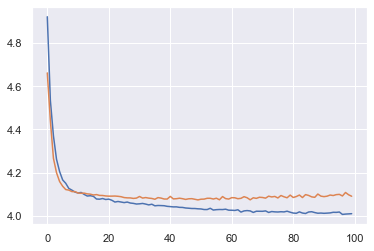

In [531]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [532]:
model.predict([[0]]).shape

(1, 121)

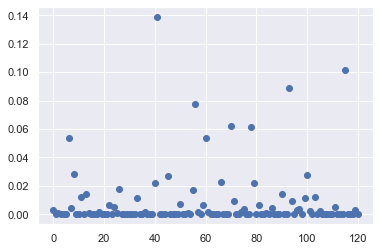

In [533]:
plt.figure()
plt.scatter(np.arange(len(hero_map)), model.predict([[0]]))

In [534]:
pick_ban_order.index[0]

0

In [535]:
df[(df['order']==0) & (df['heroName']=="Io")].shape

(43, 7)

In [536]:
df[(df['order']==0)].shape

(416, 7)

In [537]:
# raw probability from the data (over entire data)
df[(df['order']==0) & (df['heroName']=="Io")].shape[0] / df[(df['order']==0)].shape[0] * 100

10.336538461538462

In [538]:
df[(df['order']==0) & (df['heroName']=="Weaver")].shape[0] / df[(df['order']==0)].shape[0] * 100

6.730769230769231

In [539]:
df[(df['order']==0) & (df['heroName']=="Spirit Breaker")].shape[0] / df[(df['order']==0)].shape[0] * 100

11.538461538461538

In [540]:
df[(df['order']==0) & (df['heroName']=="Mars")].shape[0] / df[(df['order']==0)].shape[0] * 100

9.375

In [541]:
df[(df['order']==0) & (df['heroName']=="Queen of Pain")].shape[0] / df[(df['order']==0)].shape[0] * 100

5.769230769230769

In [542]:
df[(df['order']==0) & (df['heroName']=="Snapfire")].shape[0] / df[(df['order']==0)].shape[0] * 100

1.6826923076923077

In [543]:
draft_order_index = 0
print(pick_ban_order.iloc[[draft_order_index]])
df_pred = pd.DataFrame({'heroes':enc.categories_[0], 'proba':model.predict([[draft_order_index]])[0]}).head(121).round(2).sort_values(by='proba', ascending=False)
df_pred['perc'] = df_pred['proba'] * 100
df_pred

       pick_order name           phases
index                                  
0               1  ban  first ban phase


heroes  proba  perc
41                    Io   0.14  14.0
115               Weaver   0.10  10.0
93        Spirit Breaker   0.09   9.0
56                  Mars   0.08   8.0
70     Outworld Devourer   0.06   6.0
78         Queen of Pain   0.06   6.0
60           Monkey King   0.05   5.0
6                   Bane   0.05   5.0
45                Kunkka   0.03   3.0
100            Timbersaw   0.03   3.0
8            Beastmaster   0.03   3.0
79                 Razor   0.02   2.0
40               Invoker   0.02   2.0
66          Nyx Assassin   0.02   2.0
55                Magnus   0.02   2.0
26                  Doom   0.02   2.0
11            Brewmaster   0.01   1.0
103     Treant Protector   0.01   1.0
81                Rubick   0.01   1.0
94          Storm Spirit   0.01   1.0
99            Tidehunter   0.01   1.0
71             Pangolier   0.01   1.0
24         Death Prophet   0.01   1.0
22           Dawnbreaker   0.01   1.0
50                  Lina   0.01   1.0
59                Mirana   0.01   1.0
90              Snapfire   0.01   1.0
111                Viper   0.01   1.0
13           Broodmother   0.01   1.0
33           Enchantress   0.01   1.0
85         Shadow Shaman   0.00   0.0
82             Sand King   0.00   0.0
83          Shadow Demon   0.00   0.0
84          Shadow Fiend   0.00   0.0
118         Witch Doctor   0.00   0.0
80                  Riki   0.00   0.0
119          Wraith King   0.00   0.0
77                 Pugna   0.00   0.0
76                 Pudge   0.00   0.0
75                  Puck   0.00   0.0
74               Phoenix   0.00   0.0
73        Phantom Lancer   0.00   0.0
72      Phantom Assassin   0.00   0.0
86              Silencer   0.00   0.0
92               Spectre   0.00   0.0
87         Skywrath Mage   0.00   0.0
104        Troll Warlord   0.00   0.0
114              Warlock   0.00   0.0
113          Void Spirit   0.00   0.0
112               Visage   0.00   0.0
110           Venomancer   0.00   0.0
109      Vengeful Spirit   0.00   0.0
108                 Ursa   0.00   0.0
107              Undying   0.00   0.0
106            Underlord   0.00   0.0
105                 Tusk   0.00   0.0
102                 Tiny   0.00   0.0
88               Slardar   0.00   0.0
101               Tinker   0.00   0.0
98           Terrorblade   0.00   0.0
97      Templar Assassin   0.00   0.0
96               Techies   0.00   0.0
69                Oracle   0.00   0.0
116           Windranger   0.00   0.0
91                Sniper   0.00   0.0
117        Winter Wyvern   0.00   0.0
89                 Slark   0.00   0.0
95                  Sven   0.00   0.0
0                Abaddon   0.00   0.0
68            Omniknight   0.00   0.0
67             Ogre Magi   0.00   0.0
31           Elder Titan   0.00   0.0
30           Earthshaker   0.00   0.0
29          Earth Spirit   0.00   0.0
28           Drow Ranger   0.00   0.0
27         Dragon Knight   0.00   0.0
25             Disruptor   0.00   0.0
23                Dazzle   0.00   0.0
21           Dark Willow   0.00   0.0
20             Dark Seer   0.00   0.0
19        Crystal Maiden   0.00   0.0
18             Clockwerk   0.00   0.0
17                Clinkz   0.00   0.0
16                  Chen   0.00   0.0
15          Chaos Knight   0.00   0.0
14     Centaur Warrunner   0.00   0.0
12           Bristleback   0.00   0.0
10         Bounty Hunter   0.00   0.0
9            Bloodseeker   0.00   0.0
7               Batrider   0.00   0.0
5                    Axe   0.00   0.0
4             Arc Warden   0.00   0.0
3              Anti-Mage   0.00   0.0
2     Ancient Apparition   0.00   0.0
32          Ember Spirit   0.00   0.0
34                Enigma   0.00   0.0
35         Faceless Void   0.00   0.0
52            Lone Druid   0.00   0.0
65         Night Stalker   0.00   0.0
64             Necrophos   0.00   0.0
63      Nature's Prophet   0.00   0.0
62            Naga Siren   0.00   0.0
61             Morphling   0.00   0.0
1              Alchemist   0.00   0.0
58                 Meepo   0

In [544]:
model.predict([[draft_order_index]])[0]

array([2.96677370e-03, 1.19157254e-10, 8.22404400e-04, 1.68425729e-09,
       5.66142133e-10, 4.09884453e-11, 5.35409898e-02, 4.26865788e-03,
       2.81365998e-02, 1.89764432e-05, 8.17678703e-10, 1.23725142e-02,
       1.68563524e-10, 1.41796730e-02, 1.33579003e-03, 3.30827477e-09,
       8.13475121e-11, 1.03761652e-10, 1.39129674e-03, 9.21169391e-11,
       2.08672385e-11, 5.37920708e-10, 6.50346885e-03, 3.84325322e-10,
       5.19183837e-03, 9.42427025e-04, 1.80406235e-02, 1.14037235e-11,
       7.27662597e-09, 1.34495524e-04, 1.37951531e-04, 1.85060308e-05,
       2.29025056e-04, 1.13583570e-02, 3.12828180e-10, 9.45815870e-08,
       1.94970984e-03, 1.65074866e-07, 3.08286036e-11, 2.99779507e-11,
       2.24251952e-02, 1.38920859e-01, 7.83001951e-07, 4.11979728e-10,
       1.96082733e-10, 2.67393477e-02, 1.90719801e-11, 1.05584753e-07,
       3.42751161e-10, 4.62883781e-06, 7.27717299e-03, 2.49647219e-05,
       7.36930905e-10, 7.17931194e-04, 2.15388194e-04, 1.73039902e-02,
      

In [545]:
np.sum(model.predict([[draft_order_index]])[0])

1.0

(array([103.,   9.,   1.,   2.,   2.,   1.,   1.,   1.,   0.,   1.]),
 array([6.6788339e-13, 1.3892086e-02, 2.7784172e-02, 4.1676257e-02,
        5.5568345e-02, 6.9460429e-02, 8.3352514e-02, 9.7244598e-02,
        1.1113669e-01, 1.2502877e-01, 1.3892086e-01], dtype=float32),
 <BarContainer object of 10 artists>)

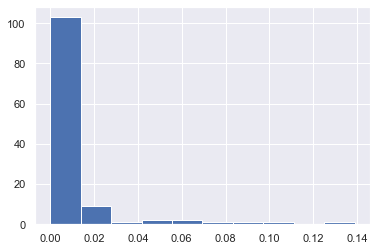

In [546]:
plt.figure()
plt.hist(model.predict([[draft_order_index]])[0])

In [547]:
# model prediction for each draft order
y_pred_all = model.predict(np.array(pick_ban_order.index).reshape(-1, 1)) * 100

In [548]:
y_pred_all.shape

(24, 121)

In [549]:
pick_ban_order

pick_order  name             phases
index                                     
0               1   ban    first ban phase
1               2   ban    first ban phase
2               3   ban    first ban phase
3               4   ban    first ban phase
4               5  pick   first pick phase
5               6  pick   first pick phase
6               7  pick   first pick phase
7               8  pick   first pick phase
8               9   ban   second ban phase
9              10   ban   second ban phase
10             11   ban   second ban phase
11             12   ban   second ban phase
12             13   ban   second ban phase
13             14   ban   second ban phase
14             15  pick  second pick phase
15             16  pick  second pick phase
16             17  pick  second pick phase
17             18  pick  second pick phase
18             19   ban    third ban phase
19             20   ban    third ban phase
20             21   ban    third ban phase
21             22   ban    third ban phase
22             23  pick   thrid pick phase
23             24  pick   thrid pick phase

In [550]:
df_pred_all = pd.DataFrame({i:y_pred_all[i] for i in pick_ban_order.index}, index=enc.categories_[0]).round(2)
df_pred_all.style.background_gradient(cmap='Blues')

In [551]:
pick_ban_order['name'].values[23]

'pick'

In [552]:
df_pred_all_heatmap = df_pred_all
df_pred_all_heatmap = df_pred_all_heatmap.rename(columns={c:pick_ban_order['name'].values[i] for i,c in enumerate(df_pred_all_heatmap.columns)})

In [553]:
df_pred_all_heatmap['sum'] = df_pred_all_heatmap.sum(axis=1)


In [554]:
df_pred_all_heatmap[['sum']].sort_values(by='sum', ascending=False)

sum
Weaver               79.750000
Mars                 76.869995
Queen of Pain        75.230003
Bane                 72.970001
Io                   71.400009
Spirit Breaker       65.269997
Monkey King          62.599998
Kunkka               61.029995
Outworld Devourer    57.459995
Beastmaster          55.979996
Razor                55.550011
Luna                 53.459995
Puck                 51.629993
Templar Assassin     51.040001
Invoker              50.619995
Tidehunter           47.630001
Wraith King          47.199997
Morphling            46.520004
Lina                 45.360004
Terrorblade          44.060001
Snapfire             43.230000
Medusa               42.180000
Ember Spirit         39.500004
Storm Spirit         38.410007
Timbersaw            35.980003
Phantom Assassin     34.680000
Death Prophet        30.999998
Grimstroke           29.750002
Night Stalker        28.920000
Faceless Void        27.990002
Legion Commander     27.789999
Disruptor            27.669998
Broodmother          26.870001
Batrider             26.350002
Nyx Assassin         26.230003
Pangolier            25.750000
Doom                 25.349995
Rubick               24.419996
Phantom Lancer       22.650000
Ursa                 22.379999
Treant Protector     22.239998
Void Spirit          22.170000
Lion                 22.100004
Ogre Magi            21.850000
Bloodseeker          21.330000
Drow Ranger          19.350002
Viper                18.270000
Shadow Demon         18.240000
Dark Seer            17.719999
Leshrac              17.190001
Gyrocopter           17.000000
Troll Warlord        16.420000
Mirana               16.230001
Enchantress          15.090000
Dark Willow          14.969999
Lifestealer          14.180001
Abaddon              13.740000
Magnus               13.440001
Clockwerk            13.249999
Brewmaster           13.120001
Lycan                13.010000
Tusk                 12.999997
Silencer             12.750001
Slardar              12.330000
Anti-Mage            10.950000
Naga Siren           10.500000
Sand King             9.990001
Hoodwink              8.540000
Venomancer            8.450000
Shadow Fiend          8.200001
Centaur Warrunner     8.070001
Dragon Knight         7.759999
Undying               7.500000
Sven                  7.460000
Earth Spirit          7.090000
Jakiro                6.910000
Tinker                6.780000
Underlord             6.780000
Ancient Apparition    6.730000
Phoenix               6.250000
Dawnbreaker           5.940000
Axe                   5.780000
Nature's Prophet      5.730000
Windranger            5.680000
Earthshaker           4.710000
Juggernaut            4.460000
Visage                4.179999
Tiny                  4.060000
Winter Wyvern         3.830000
Skywrath Mage         3.809999
Oracle                3.640000
Elder Titan           3.070000
Sniper                2.860000
Clinkz                2.670000
Chaos Knight          2.550000
Bristleback           2.540000
Necrophos             2.330000
Huskar                2.100000
Dazzle                2.040000
Riki                  1.920000
Techies               1.910000
Spectre               1.710000
Slark                 1.640000
Witch Doctor          1.590000
Chen                  1.560000
Enigma                1.410000
Crystal Maiden        1.260000
Arc Warden            1.240000
Shadow Shaman         1.010000
Vengeful Spirit       0.970000
Pugna                 0.900000
Alchemist             0.880000
Warlock               0.820000
Pudge                 0.750000
Bounty Hunter         0.670000
Lone Druid            0.650000
Zeus                  0.640000
Keeper of the Light   0.590000
Lich                  0.310000
Meepo                 0.000000
Omniknight            0.000000

<AxesSubplot:title={'center':'percentage prediction'}>

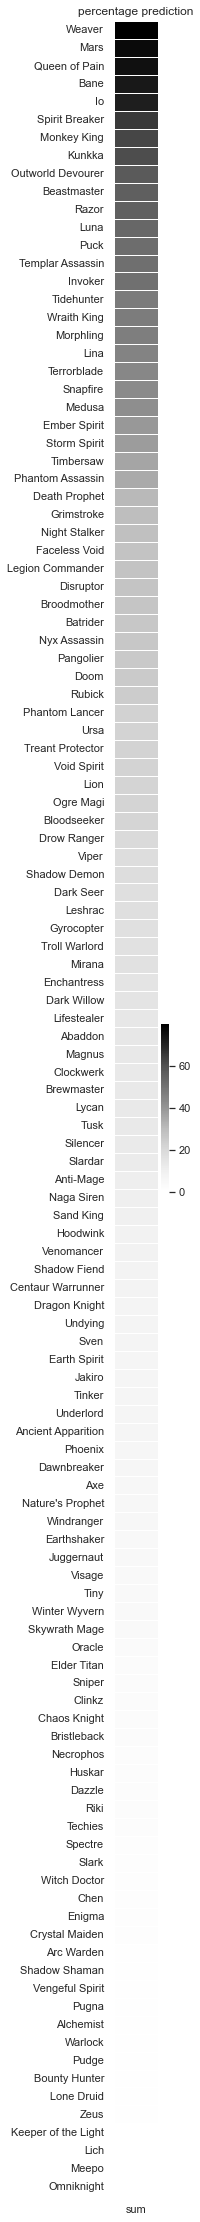

In [555]:
fig, ax = plt.subplots(1, 1, figsize=(1,40))
ax.set_title('percentage prediction')
sns.heatmap(df_pred_all_heatmap.sort_values(by='sum', ascending=False)[['sum']], linewidths=0.5, ax=ax, cmap="Greys")

<AxesSubplot:title={'center':'percentage prediction'}>

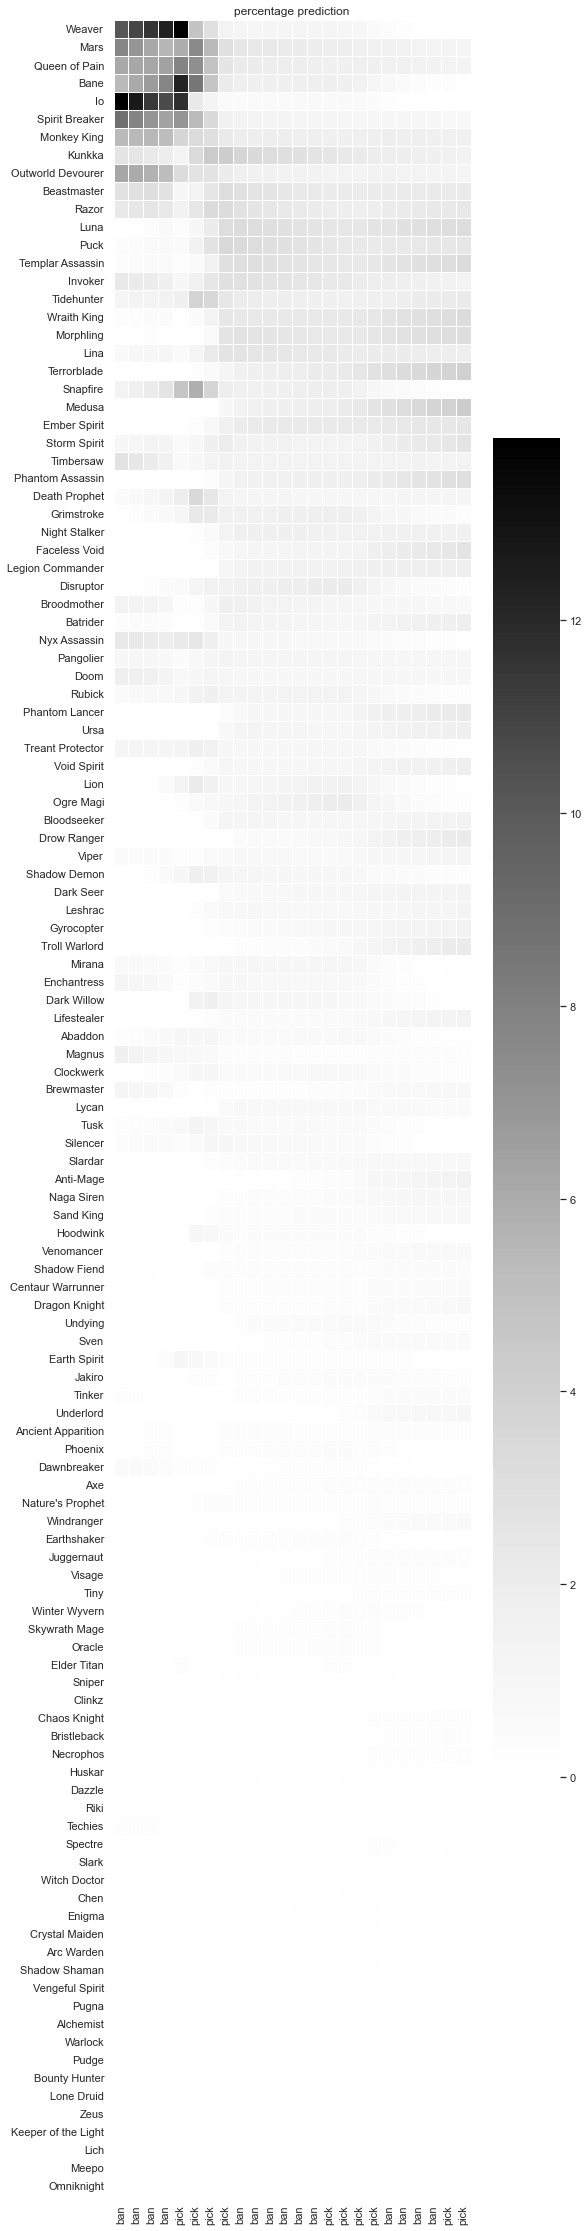

In [556]:
fig, ax = plt.subplots(1, 1, figsize=(8,40))
ax.set_title('percentage prediction')
# sns.heatmap(df_pred_all_heatmap, linewidths=0.5, ax=ax, cmap="viridis", vmin=1, cbar_kws={'extend': 'min'})
# sns.heatmap(df_pred_all_heatmap, linewidths=0.5, ax=ax, cmap="Greys")
sns.heatmap(df_pred_all_heatmap.sort_values(by='sum', ascending=False).drop(columns=['sum']), linewidths=0.5, ax=ax, cmap="Greys")